# Visual Inspection of Motorcycle Connecting Rods
Students should develop a software system aimed at visual inspection of motorcycle connecting rods. The system should be able to analyse the dimensions of two different types of connecting rods to allow a vision-guided robot to pick and sort rods based on their type and dimensions. The two rod types are characterized by a different number of holes: Type A rods have one hole whilst Type B rods have two holes.

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

# Used to compute euler number
import mahotas

from scipy.spatial import distance as dist

In [3]:
folder_path = os.path.join(os.getcwd(), "images")

# all image processings will be stored into a dictionary
first_task = dict.fromkeys(["Tesi00.bmp", "Tesi01.bmp", "Tesi12.bmp", "Tesi21.bmp", "Tesi31.bmp", "Tesi33.bmp"], None)
second_task_1 = dict.fromkeys(["Tesi44.bmp", "Tesi47.bmp", "Tesi48.bmp"], None)
second_task_2 = dict.fromkeys(["Tesi49.bmp", "Tesi50.bmp","Tesi51.bmp."], None)
second_task_3 = dict.fromkeys(["Tesi90.bmp","Tesi92.bmp","Tesi98.bmp"], None)

def load_image(path, image):
    """
    Load image from path
    """
    img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
    return img

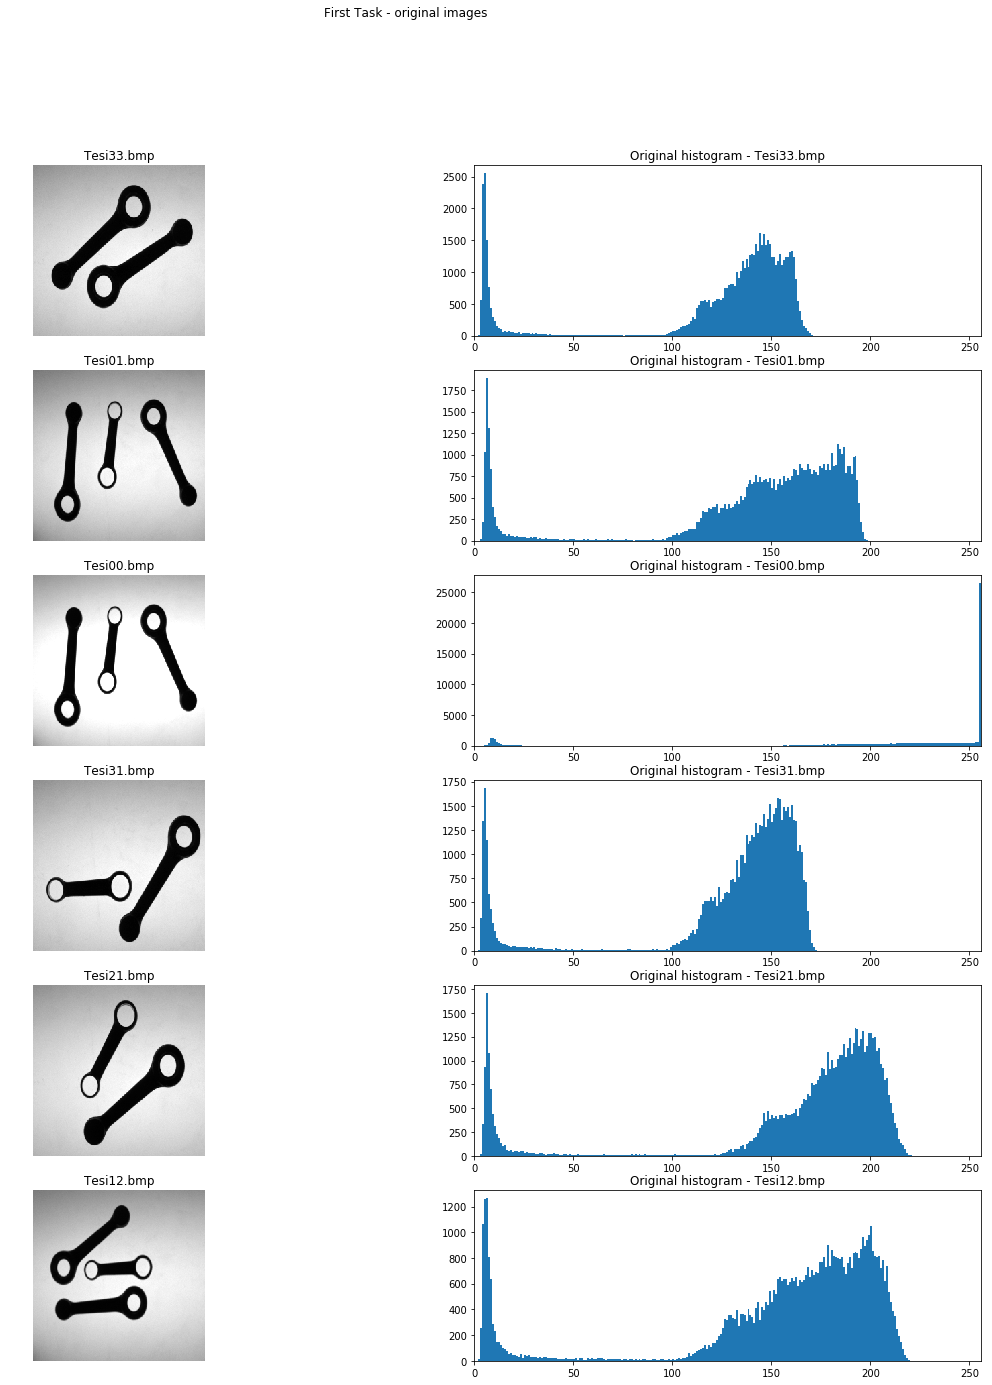

In [4]:
for key in first_task.keys():
    first_task[key] = {"original" : load_image(folder_path, key)}

fig, axs = plt.subplots(nrows=len(first_task), ncols=2, figsize=(20, 22))
fig.suptitle('First Task - original images')
for i, key in enumerate(first_task.keys()):
    # plot original image
    axs[i, 0].imshow(first_task[key]["original"], cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title(key)

    # plot histogram
    axs[i, 1].set_xlim([0,256])
    axs[i, 1].hist(first_task[key]["original"].ravel(), 256, [0, 256])
    axs[i, 1].set_title("Original histogram - " + key) 

plt.show()

Before thresholding, let's apply a local operator like Bilateral filter denoise the image and keep shap edges.

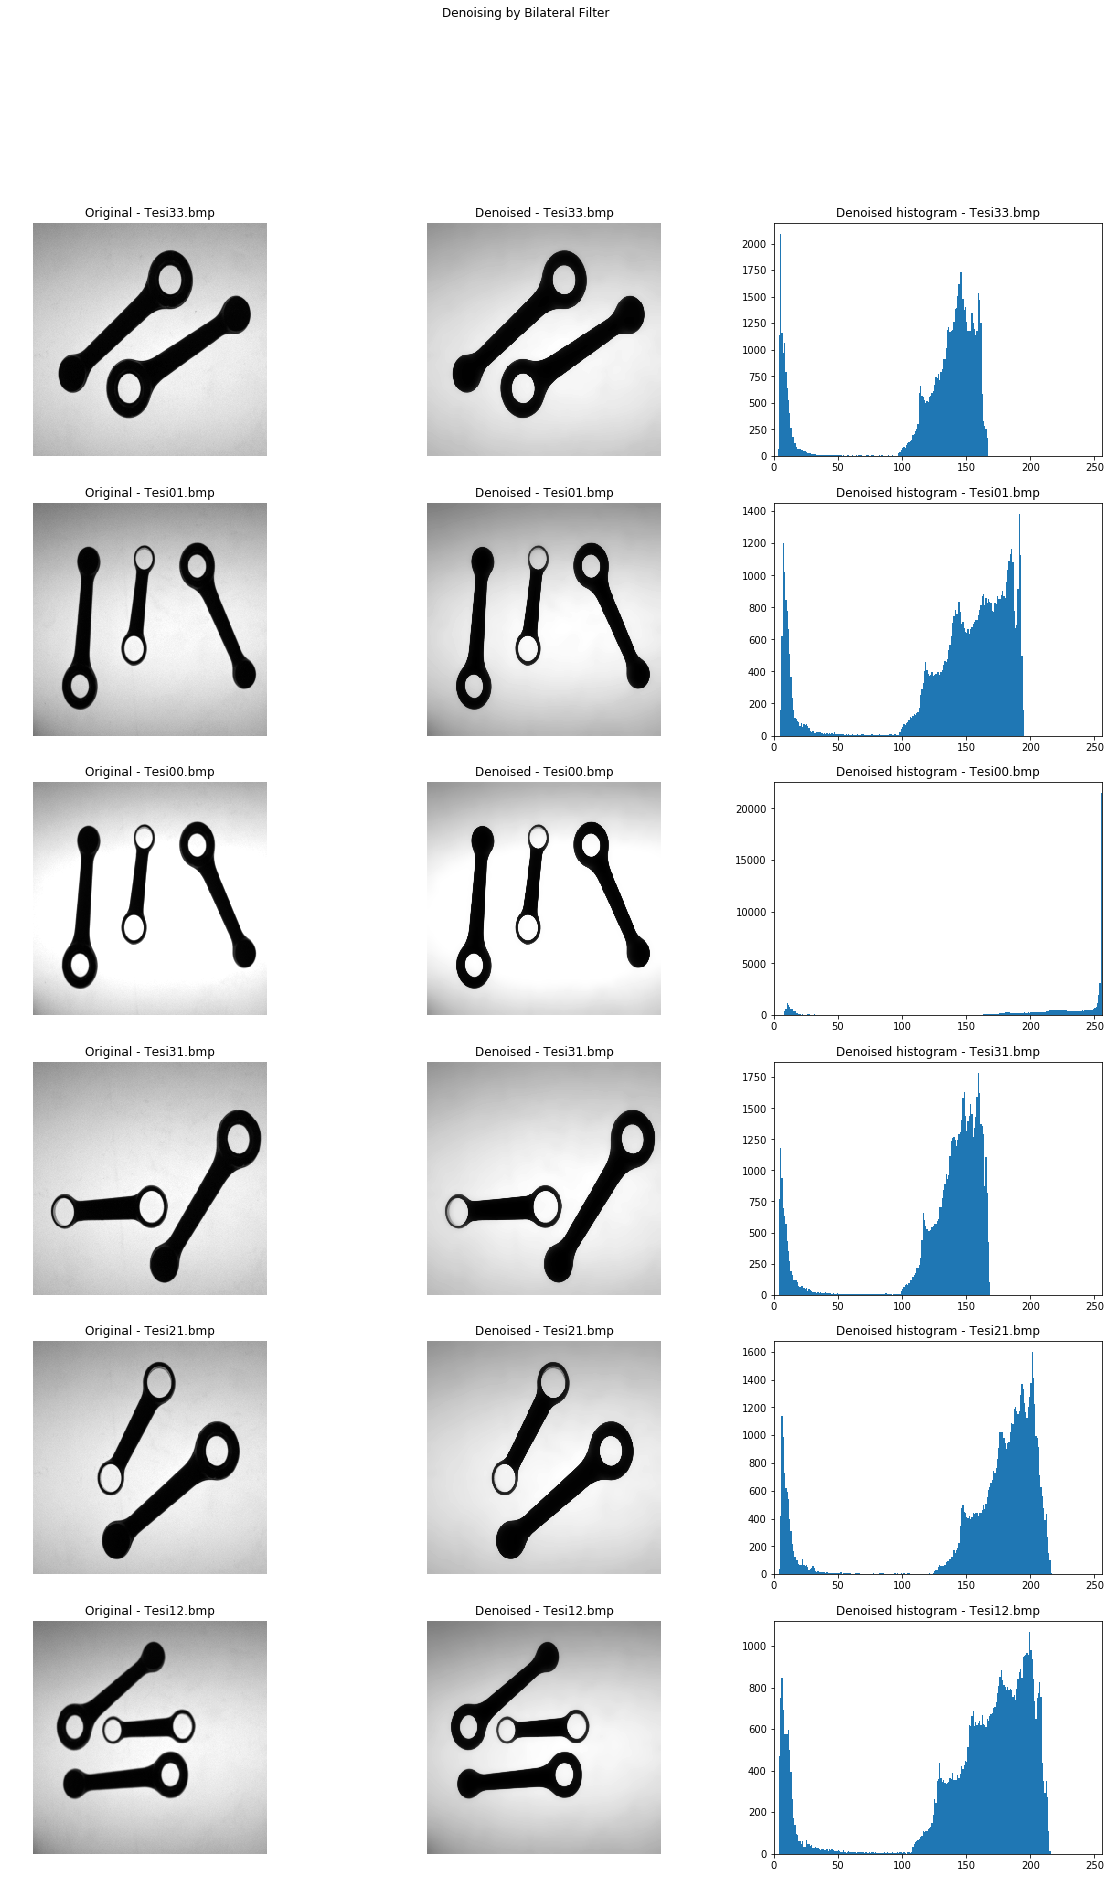

In [5]:
fig, axs = plt.subplots(nrows=len(first_task), ncols=3, figsize=(20, 30))
fig.suptitle('Denoising by Bilateral Filter')
for i, key in enumerate(first_task.keys()):
    # plot original image
    axs[i, 0].imshow(first_task[key]["original"], cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title("Original - " + key)

    # plot images after bilateral filter
    first_task[key]["denoised"] = cv2.bilateralFilter(first_task[key]["original"], d=19, sigmaColor=45, sigmaSpace=3)
    axs[i, 1].imshow( first_task[key]["denoised"], cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title("Denoised - " + key)

    # plot histogram of images after  bilateral filter
    axs[i, 2].set_xlim([0,256])
    axs[i, 2].hist( first_task[key]["denoised"].ravel(), 256, [0, 256])
    axs[i, 2].set_title("Denoised histogram - " + key)

plt.show()

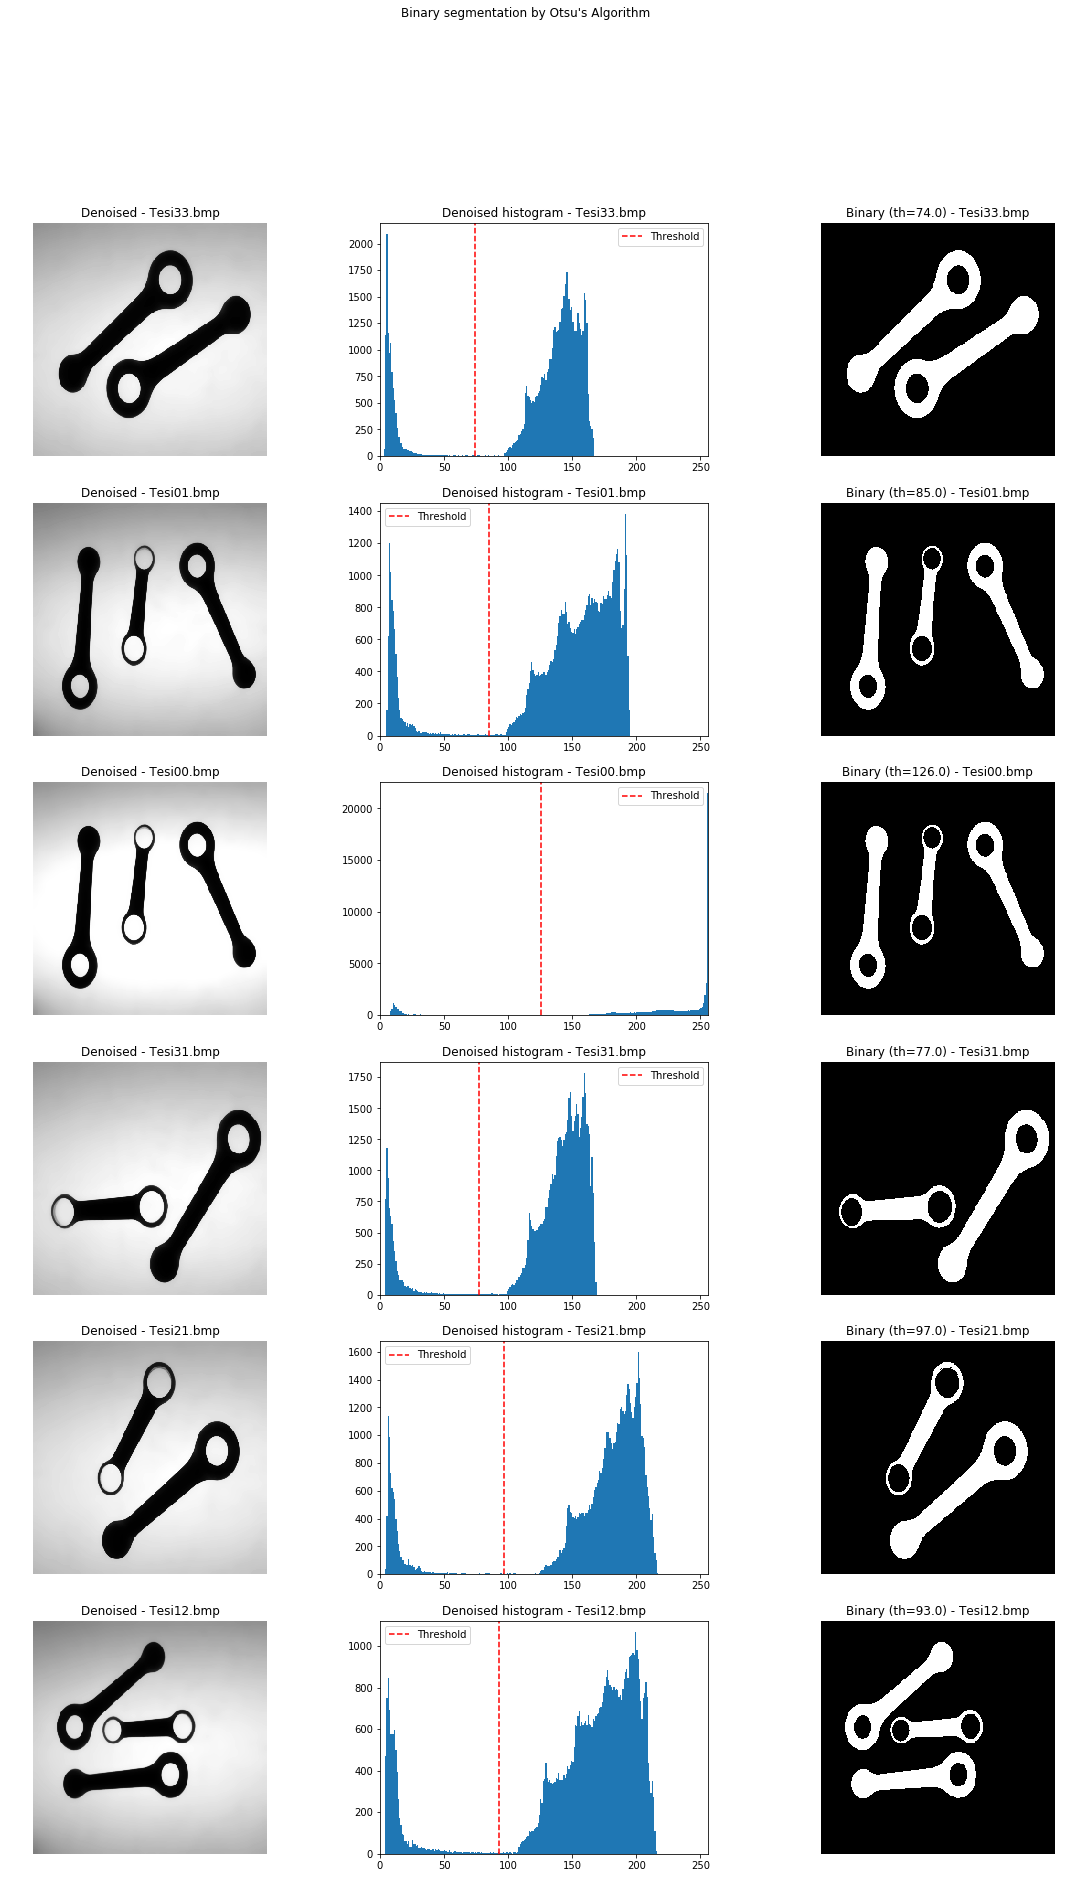

In [6]:
fig, axs = plt.subplots(nrows=len(first_task), ncols=3, figsize=(20, 30))
fig.suptitle("Binary segmentation by Otsu's Algorithm")
for i, key in enumerate(first_task.keys()):
    # plot denoised image
    axs[i, 0].imshow(first_task[key]["denoised"], cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title("Denoised - " + key)

    # plot histogram of images after bilateral filter
    axs[i, 1].set_xlim([0,256])
    axs[i, 1].hist(first_task[key]["denoised"].ravel(), 256, [0, 256])
    axs[i, 1].set_title("Denoised histogram - " + key)

    # plot images after segmentation
    threshold, binary_img = cv2.threshold(first_task[key]["denoised"], 0, 255, cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
    first_task[key]["binary"] = binary_img
    axs[i, 1].axvline(x=threshold, color='r',linestyle='--', label='Threshold')
    axs[i, 1].legend(loc='best')
    axs[i, 2].imshow(first_task[key]["binary"], cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 2].set_title("Binary (th="+str(threshold)+") - " + key)

Then, we proceed with a connected component analysis:

In [7]:
def connected_componentets_analysis(img, connectivity=8, area_threshold=100):
    """
    Compute the number of connected components in the image

    Parameters
    ----------
    img : numpy.ndarray
        Binary image
    connectivity : int, optional
        Connectivity of the connected components. The default is 8.
    area_threshold : int, optional
        Area threshold to filter connected components. The default is 100.
    """
    n_labels, label_ids, stats, centroid = cv2.connectedComponentsWithStats(img, connectivity=connectivity)
            
    for i in range(1, n_labels):
        # Area of the component
        area = stats[i, cv2.CC_STAT_AREA]

        if (area < area_threshold):
            # remove the components that are smaller than the threshold
            np.delete(stats, i)
            np.delete(centroid, i)
            label_ids[label_ids == i] = 0
            n_labels -= 1
    return n_labels, label_ids, stats, centroid


def show_blobs(n_labels, label_ids, stats, centroid, bbox_color=5):
    """
    Show the blobs in the image
    """
    output = np.zeros(label_ids.shape, dtype="uint8")
    for i in range(1, n_labels):
        # stores all the IDs of the components on the each pixel that has the same dimension as the threshold
            output[label_ids == i] = i

            # Now extract the coordinate points
            x1 = stats[i, cv2.CC_STAT_LEFT]
            y1 = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]

            # draw bounding box and centroid
            cv2.rectangle(output, (x1, y1), (x1+w, y1+h), bbox_color, 1) 
            cv2.circle(output, (int(centroid[i][0]), int(centroid[i][1])), 4, bbox_color, -1)
    return output

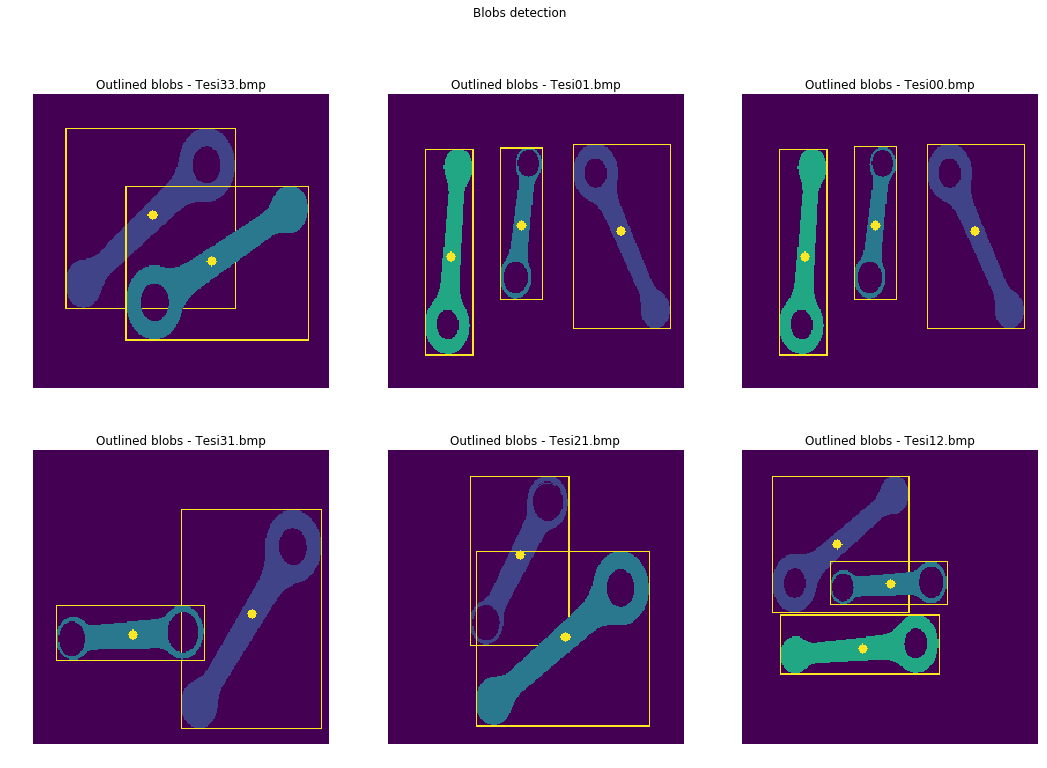

In [8]:
nrows=int(np.ceil(len(first_task)/3))
ncols=3
area_threshold = 100

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12))
fig.suptitle("Blobs detection")
for n in range(nrows):
    for m in range(ncols):
        k = n*ncols + m
        if k < len(first_task):
            # perform connected components analysis
            key = list(first_task.keys())[k]
            n_labels, label_ids, stats, centroid = connected_componentets_analysis(first_task[key]["binary"], area_threshold=area_threshold)
            
            # store the results
            first_task[key]["blobs"] = {"n_labels": n_labels, "label_ids": label_ids, "stats": stats, "centroid": centroid}

            # highlight blobs
            output = show_blobs(**first_task[key]["blobs"])
            
            # plot connected components
            axs[n, m].imshow(output)
            axs[n, m].axis('off')
            axs[n, m].set_title("Outlined blobs - " + key)

For each connecting rod appearing in the image, the vision system should provide the following information:
1. Type of rod (A or B);
2. Position and orientation modulo $\pi$;
3. Length $L$, width $W$, width at the barycenter $W_b$;
4. For each hole, position of the centre and diameter size.

In [9]:
def get_blob(ids, label):
    """
    Get the blob with the given label

    Parameters
    ----------
    ids : numpy.ndarray
        Image with the labels of the connected components
    label : int
        Label of the blob to be extracted

    Returns
    -------
    numpy.ndarray
        Binary image with the blob

    """
    blob = np.zeros(ids.shape, dtype=np.uint8)
    blob[ids == label] = 1
    return blob

In [10]:
def haralick_circularity(contour, centroid):
    '''
    Compute Haralick's circularity measure
    '''
    distances = [dist.euclidean(coord, centroid) for coord in contour]
    std = np.std(distances)
    return np.mean(distances) / np.std(distances) if std > 0 else float('INF')

Image moments help you calculate some features like center of mass of the object, area of the object etc.

The function `cv2.moments()` gives a dictionary of all moment values calculated. From this moments, you can extract useful data like area, centroid etc. Centroid is given by the relations, $C_x=\frac{M_{10}}{M_{00}}$ and $C_y=\frac{M_{01}}{M_{00}}$.

In [120]:
def get_holes_stats(contours, haralick_threshold=6, area_threshold=50):
    """
    For each hole in the blob, compute the position of the centre and diameter size
    """
    holes = []
    for i in range(len(contours)):
        # compute the center of the contour
        M = cv2.moments(contours[i])
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        # compute the area of the contour
        area = cv2.contourArea(contours[i])

        # check if the contour is big enough
        if area > area_threshold:
            # compute haralick's circularity
            circularity_score = haralick_circularity(contours[i], (cX, cY))

            # check if the contour is circular enough
            if circularity_score > haralick_threshold:
                diameter = np.sqrt(4*area/np.pi)
                holes.append({"cX": cX, "cY": cY, "diameter": diameter})
    return holes

In [123]:
def get_blob_mer(contour):
    """
    Compute the minimum enclosing rectangle of the blob
    """
    rect = cv2.minAreaRect(contour)
    barycenter, (width, height), rotation = rect
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return box

In [162]:
def get_width_barycenter(mer, angle):
    """
    Given the minimum enclosing rectangle of the blob, compute the width at the barycenter
    """
    # compute the angle of the mer
    mer_angle = np.arctan2(mer[1][1] - mer[0][1], mer[1][0] - mer[0][0])
    # compute the angle between the mer and the x-axis
    angle = mer_angle - angle
    # compute the width at the barycenter
    width = np.abs(np.cos(angle))*np.linalg.norm(mer[1] - mer[0])
    return width

   

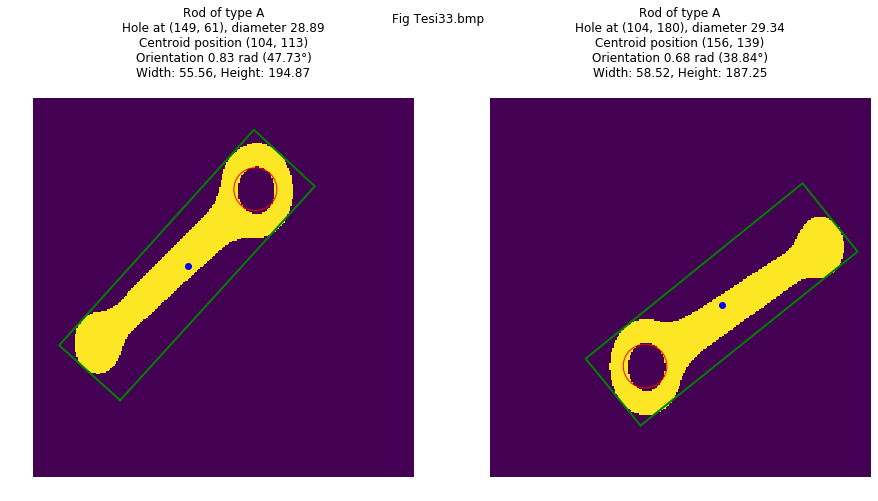

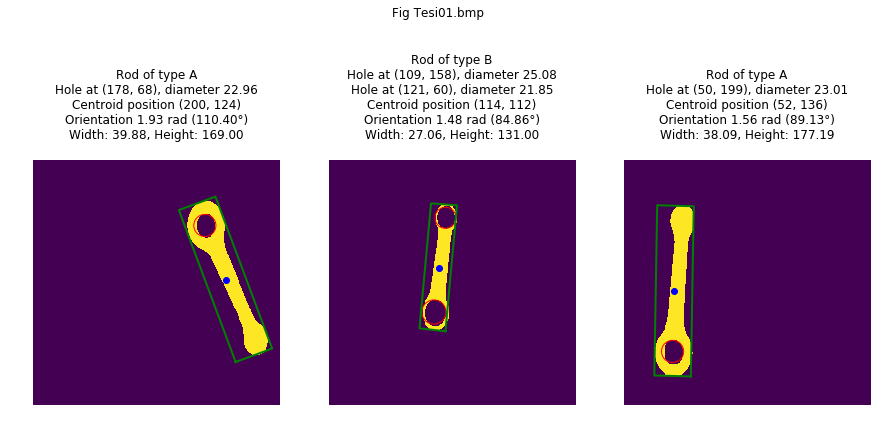

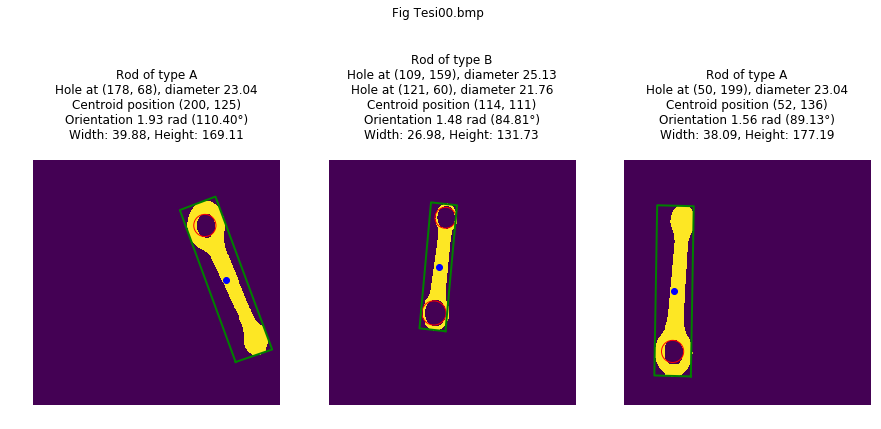

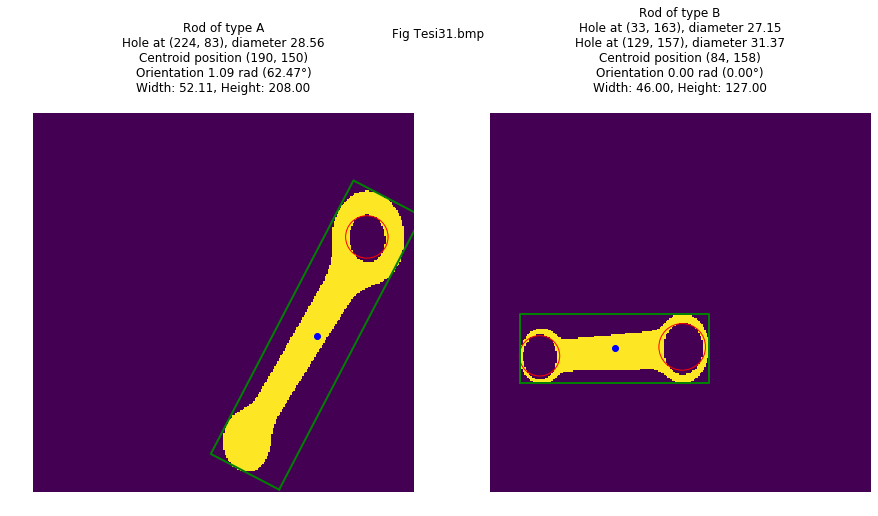

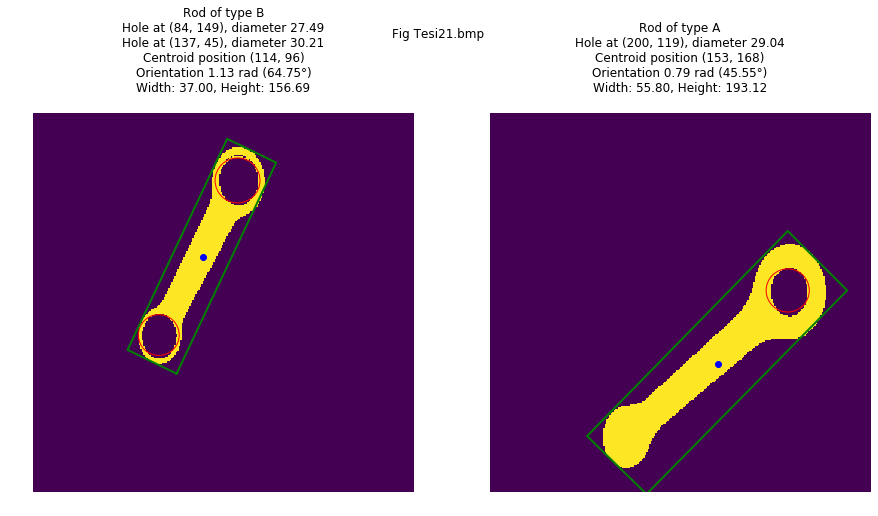

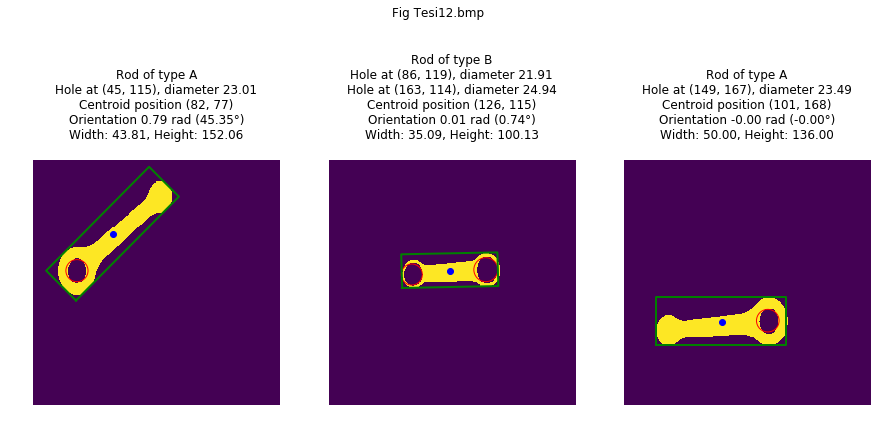

In [167]:
for key in first_task.keys():
    n_labels = first_task[key]["blobs"]["n_labels"]
    labels_ids = first_task[key]["blobs"]["label_ids"]
    stats = first_task[key]["blobs"]["stats"]

    fig, axs = plt.subplots(nrows=1, ncols=n_labels-1, figsize=(15, 8))
    fig.suptitle("Fig "+key)
    for i in range(1, n_labels):
        blob = get_blob(labels_ids, i)

        # find contours of the highlighted blob
        _, contours, hierarchy = cv2.findContours(blob, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # compute the holes to classify the type of the rod
        holes = get_holes_stats(contours)

        title = ""

        if len(holes) == 1:
            # rod is of type A
            title+="Rod of type A\n"
        elif len(holes) == 2:
            # rod is of type B
            title+="Rod of type B\n"
        else:
            # rod is unknown type
            title+="Rod of unknown type\n"

        for hole in holes:
            title+="Hole at ({:.0f}, {:.0f}), diameter {:.2f}\n".format(hole["cX"], hole["cY"], hole["diameter"])

            # plot the hole
            axs[i-1].add_patch(plt.Circle((hole["cX"], hole["cY"]), hole["diameter"]/2, color='r', fill=False))
            
        # compute the minimum enclosing rectangle
        rect = cv2.minAreaRect(contours[0])
        centroid, dimesions, rotation = rect
        
        # get the 4 corners of the rectangle
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        box = np.vstack((box, box[0]))

        # plot the centroid
        axs[i-1].plot(centroid[0], centroid[1], 'bo')

        # plot  rectangle
        axs[i-1].plot(box[:,0], box[:,1], color='g', linewidth=2)

        major_axis_length = np.max(dimesions)
        minor_axis_length = np.min(dimesions)

        # convert the rotation angle to actual angle in degrees
        # https://theailearner.com/tag/angle-of-rotation-by-cv2-minarearect/
        # https://stackoverflow.com/questions/15956124/minarearect-angles-unsure-about-the-angle-returned
        orientation_deg = 90 - rotation if dimesions[0] < dimesions[1] else -rotation
        
        # convert orientation to radians modulo 2pi
        orientation_rad = np.deg2rad(orientation_deg)

        # print stats on the title
        title+="Centroid position ({:.0f}, {:.0f})\n".format(centroid[0], centroid[1])
        title+="Orientation {:.2f} rad ({:.2f}°)\n".format(orientation_rad, orientation_deg)
        title+="Width: {:.2f}, Height: {:.2f}\n".format(minor_axis_length, major_axis_length)
        
        # plot the blob
        axs[i-1].imshow(blob)
        axs[i-1].axis('off')
        axs[i-1].set_title(title)
       